# Application of linear response theory method to individual ensemble members (CESM)
Here, we apply the linear response theory method to individual ensemble members. This is done using the block bootstrapping methodology. We compare to the true value from the notebook true_freshwater_fluxes_integration.ipynb and then apply significance criteria on the salinity trends to select only for members with high enough signal to noise ratio.

In [1]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe
import warnings
import os

In [ ]:
# Load in salt and temp fields from each ensemble member. These pickled files were created in the file processing_salt_temp.py

import pickle
with open('/scratch/abf376/freshwater_flux_linresp/model_tests/pickled_files_regriddedobjects/regridded_salt_1920to2005_historical', "rb") as fp:   # Unpickling
    regridded_salt= pickle.load(fp)

with open("/scratch/abf376/freshwater_flux_linresp/model_tests/pickled_files_regriddedobjects/regridded_salt_2006to2080_rcp8.5", "rb") as fp:   # Unpickling
    regridded_salt_2005on= pickle.load(fp)
    
with open("/scratch/abf376/freshwater_flux_linresp/model_tests/pickled_files_regriddedobjects/regridded_temp", "rb") as fp:   # Unpickling
    regridded_temp= pickle.load(fp)
    
with open("/scratch/abf376/freshwater_flux_linresp/model_tests/pickled_files_regriddedobjects/regridded_temp_2006to2080_rcp8.5", "rb") as fp:   # Unpickling
    regridded_temp_2005on= pickle.load(fp)
    

salt_pre2005_list=[] #make list of salt pre 2005 and give it correct coordinates
for i in range(0,34):
    s=regridded_salt[i].rename({'y': 'latitude','x': 'longitude'})
    s=s.assign_coords(latitude=s.lat[:,0],longitude=s.lon[0,:])
    salt_pre2005_list.append(s)

salt_2005on_list=[] #make list of salt post 2005 and give it correct coordinates
for i in range(0,34):
    s=regridded_salt_2005on[i].rename({'y': 'latitude','x': 'longitude'})
    s=s.assign_coords(latitude=s.lat[:,0],longitude=s.lon[0,:])
    salt_2005on_list.append(s)
    
salt_list=[] #combine salt lists from the two time periods and then cut to 1975 to 2025
for i in range(0,34):
    s=xr.concat([salt_pre2005_list[i],salt_2005on_list[i]],dim="time")
    salt_list.append(s[12*55:12*105,:,:]) #cut to 1975 to 2025
    
#same as above but for temperature
temp_pre2005_list=[]
for i in range(0,34):
    s=regridded_temp[i].rename({'y': 'latitude','x': 'longitude'})
    s=s.assign_coords(latitude=s.lat[:,0],longitude=s.lon[0,:])
    temp_pre2005_list.append(s)

temp_2005on_list=[]
for i in range(0,34):
    s=regridded_temp_2005on[i].rename({'y': 'latitude','x': 'longitude'})
    s=s.assign_coords(latitude=s.lat[:,0],longitude=s.lon[0,:])
    temp_2005on_list.append(s)
    
temp_list=[]
for i in range(0,34):
    s=xr.concat([temp_pre2005_list[i],temp_2005on_list[i]],dim="time")
    temp_list.append(s[12*55:12*105,:,:]) #cut to 1975 to 2025

In [ ]:
#define an area matrix
import sys
sys.path.append('/scratch/abf376/freshwater_flux_linresp/tools')
from area_grid import *

area=area_grid(latitudes=np.array(salt_list[0].latitude),longitudes=salt_list[0].longitude)
area=xr.DataArray(area,dims=["latitude","longitude"],coords=[salt_list[0].latitude,salt_list[0].longitude])

## Example of application to one specific ensemble member

In [ ]:
real=0 #realization in the list
n=6


%load_ext autoreload 
%autoreload 2

from clustering_tools import * #do clustering of the first 5 years of the realization
mean_con,sigma_con,weights_con,gm=GMM_timedep(salt_list[real][0*12:5*12,:,:].mean('time').where(salt_list[real][0,:,:].latitude<65),n,'CESM data, mean 1975 to 1980',matching_paper=1)

In [ ]:
from clustering_tools import clusters
%load_ext autoreload
%autoreload 2

y,a2=clusters(gm,salt_list[real][0*12:5*12,:,:].mean('time'),'Location of each Gaussian, categorized by years 1975-1980 (mean), CESM',n,matching_paper=1) #put on the last parameter if want colours to match the line plots of salinity

In [ ]:
def area_weighted_disjoint(area,i,salt_surface,thing_to_weight,x,a2):
    return ((thing_to_weight*area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()/((area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()

In [ ]:
#Here we find the mean salinity and temperature in each region found by the GMM above.
x=np.linspace(31,38,10000)

s=(salt_list[real][0*12:5*12,:,:].mean('time')).where(salt_list[real][0,:,:].latitude<65)

salt_cesm_member=np.empty([50,n])
temp_cesm_member=np.empty([50,n])
for j in range(0,50):
    s_new=(salt_list[real][j*12:(j+1)*12,:,:].mean('time')).where(salt_list[real][0,:,:].latitude<65)
    t_new=(temp_list[real][j*12:(j+1)*12,:,:].mean('time')).where(temp_list[real][0,:,:].latitude<65)
    for i in range(0,n):
        salt_cesm_member[j,i]=area_weighted_disjoint(area,i,s,s_new,x,a2)
        temp_cesm_member[j,i]=area_weighted_disjoint(area,i,s,t_new,x,a2)
change_cesm_member=salt_cesm_member[:,:]-np.mean(salt_cesm_member[0:2,:],0)
change_cesm_temp_member=temp_cesm_member[:,:]-np.mean(temp_cesm_member[0:2,:],0)

change_cesm_member=change_cesm_member[0:45,:] #cut to the first 45 years (1975 to 2019)
change_cesm_temp_member=change_cesm_temp_member[0:45,:] #cut to the first 45 years (1975 to 2019)

Text(0.5, 1.0, 'Change in salinity in each region, CESM member 0')

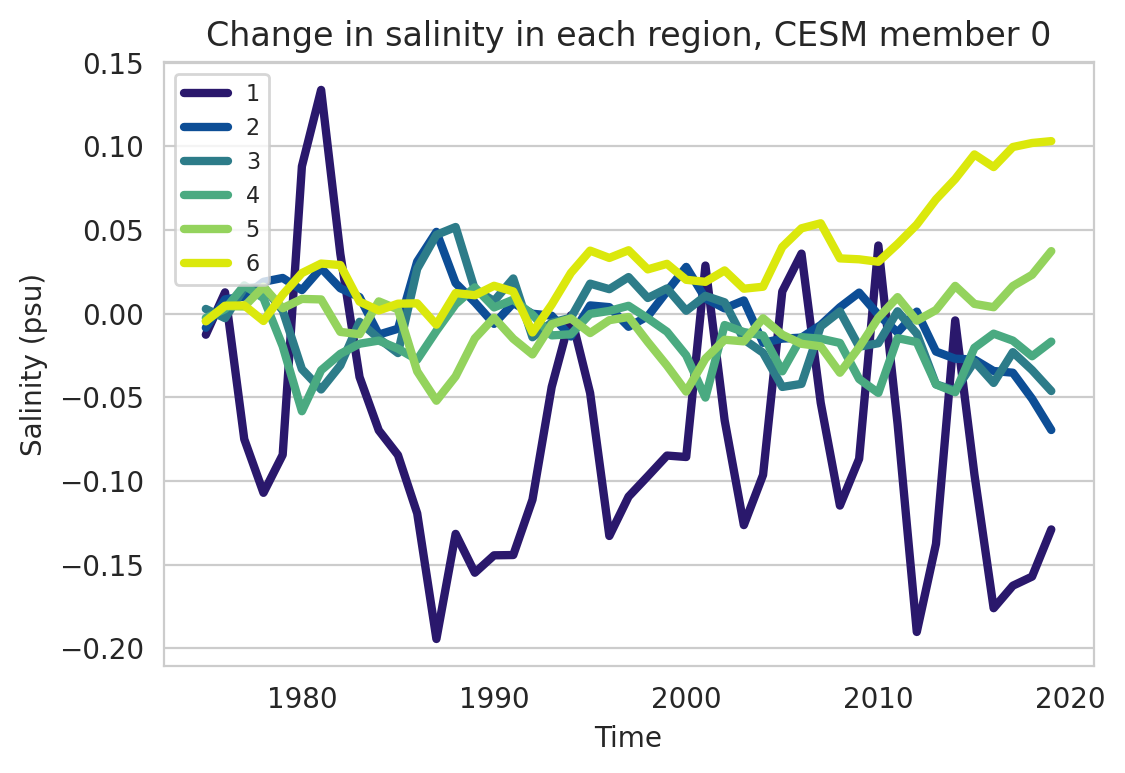

In [8]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1975,2019,45),change_cesm_member,linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, CESM member '+ str(real))

Text(0.5, 1.0, 'Change in temperature in each region, CESM member 0')

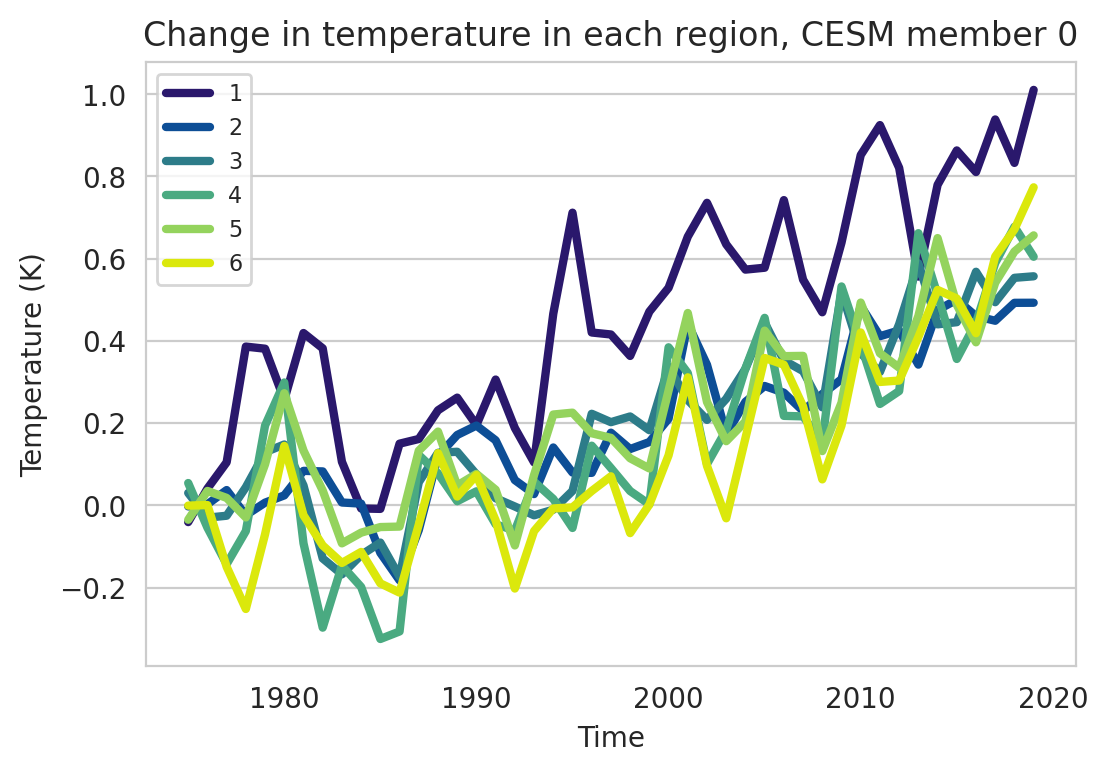

In [9]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1975,2019,45),change_cesm_temp_member,linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Change in temperature in each region, CESM member '+ str(real))

In [10]:
#Bootstrap around trend to create artificial ensemble. This follows the methodology of McKinnon et al 2017

trend=np.empty([45,6])
pvalue=np.empty([6])
for i in range(0,6):
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_cesm_member[:,i], alternative='two-sided')
    trend[:,i]=p.intercept+p.slope*np.linspace(0,44,45)
    pvalue[i]=p.pvalue

#Find the trend for each region and then block bootstrap
trend_temp=np.empty([45,6])
for i in range(0,6):
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_cesm_temp_member[:,i], alternative='two-sided')
    trend_temp[:,i]=p.intercept+p.slope*np.linspace(0,44,45)

from recombinator.block_bootstrap import circular_block_bootstrap

# number of replications for bootstraps (number of resampled time-series to generate)
B = 500

y_star_cb \
    = circular_block_bootstrap(np.concatenate([change_cesm_member-trend,change_cesm_temp_member-trend_temp],axis=1), 
                               block_length=2, 
                               replications=B, replace=True)
bootstrap_salt=y_star_cb[:,:,0:6]
bootstrap_temp=y_star_cb[:,:,6:12]

#so we now have 3000 "members" from performing block bootstrapping with the 1 member that we had. Let's put them now in a list
salt_list_bootstrap=[]
for i in range(0,B):
    salt_list_bootstrap.append(trend+bootstrap_salt[i,:,:])

temp_list_bootstrap=[]
for i in range(0,B):
    temp_list_bootstrap.append(trend_temp+bootstrap_temp[i,:,:])

Text(0, 0.5, 'Autocorrelation')

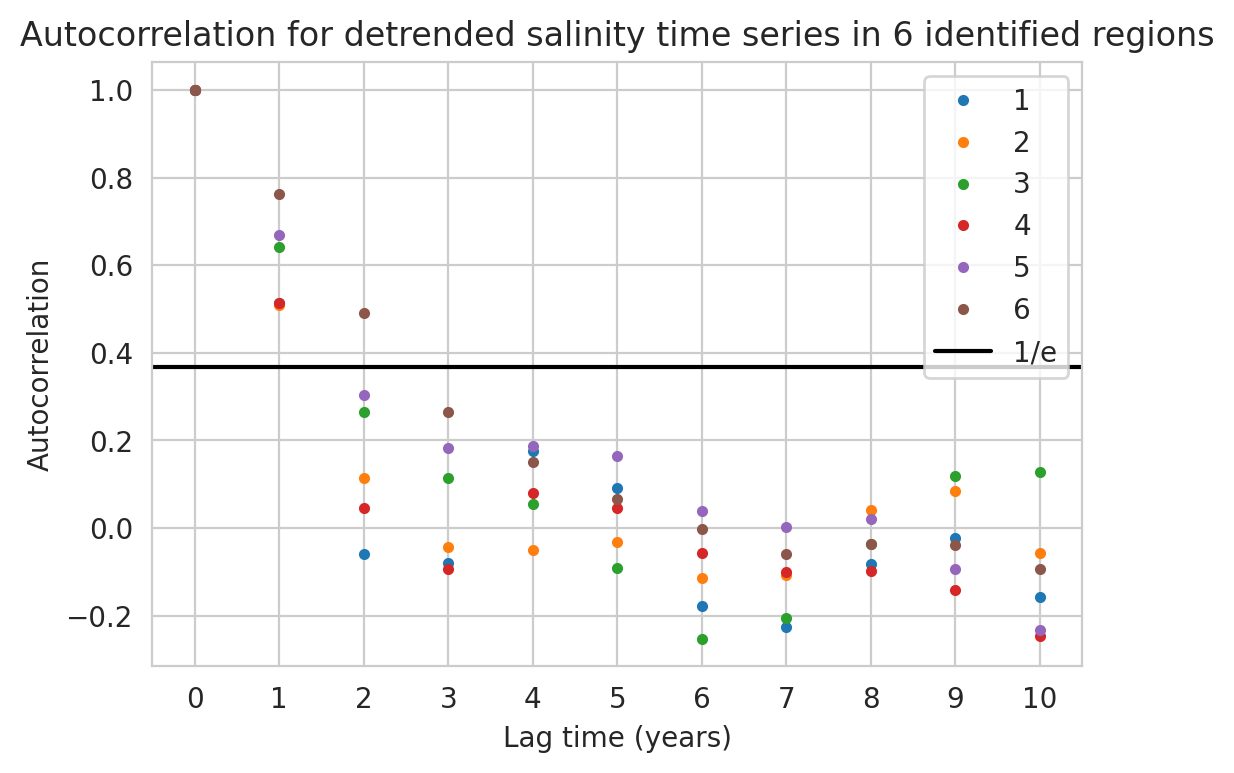

In [11]:
#One way to decide on the approximate window for block bootsrapping is looking at the autocorrelation timescale of the data. (This is how we chose 2 years above)
import statsmodels.api as sm

#calculate autocorrelations
auto_salt=np.empty([11,6])
auto_temp=np.empty([11,6])
for i in range(0,6):
    auto_salt[:,i]=sm.tsa.acf(change_cesm_member[:,i]-trend[:,i],nlags=10)
    auto_temp[:,i]=sm.tsa.acf(change_cesm_temp_member[:,i]-trend_temp[:,i],nlags=10)



plt.plot(np.linspace(0,10,11),auto_salt,'.')
plt.axhline(1/np.e,color='black') #compare against e folding 
plt.legend(['1','2','3','4','5','6','1/e'])
plt.title('Autocorrelation for detrended salinity time series in 6 identified regions')
plt.xlabel('Lag time (years)')
plt.xticks(np.linspace(0,10,11))
plt.ylabel('Autocorrelation')

In [12]:
#Apply linear response theory to the artificial ensemble

from linear_response_tools import linear_response_list_bootstrap
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    change_water1, change_heat1=linear_response_list_bootstrap(salt_list_bootstrap,temp_list_bootstrap,salt_list[real][0:45*12,:,:],n,a2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
#we can print the mean and standard deviation of the freshwater response and of the heat flux response
print('The freshwater response for ensemble member '+str(real)+' is ' + str(change_water1.mean()) +' pm '+str(change_water1.std())+ ' as a proportion of the FAFMIP perturbation')
print('The heat flux response for ensemble member '+str(real)+' is ' + str(change_heat1.mean()) +' pm '+str(change_heat1.std())+ ' as a proportion of the FAFMIP perturbation')

The freshwater response for ensemble member 0 is 0.3302128732754811 pm 0.14545309378603696 as a proportion of the FAFMIP perturbation
The heat flux response for ensemble member 0 is 0.5838316434821254 pm 0.08840941641233575 as a proportion of the FAFMIP perturbation


## Applying to all ensemble members
Above, we showed an example of applying linear response theory to one individual ensemble member by first producting an artificial ensemble using block bootstrapping. We now want to test on all 34 members of the ensemble

In [2]:
# The .py file that runs the above process that we outlined through all 34 members is called run_bootstrap_cesm_ensemble.py
#Let's load in the output from that file here that was pickled

import os
cwd = os.getcwd() #current working directory


#Here's files that were run area weighted
import pickle
with open(cwd+"/pickled_files/bootstrap_mean_3000_areaweight", "rb") as fp:   # Unpickling
    trend_uncertainty_bootstrap_mean_method1= pickle.load(fp)

with open(cwd+"/pickled_files/bootstrap_std_3000_areaweight", "rb") as fp:   # Unpickling
    trend_uncertainty_bootstrap_std_method1= pickle.load(fp)
    

#unpickle true fluxes from true_freshwater_fluxes.ipynb 
import pickle
with open(cwd+"/pickled_files/freshwater_fluxes_integration_mean_boot_new", "rb") as fp:   #Unpickling
    mean_boot=pickle.load(fp)
with open(cwd+"/pickled_files/freshwater_fluxes_integration_std_boot_new", "rb") as fp:   #Unpickling
    std_boot=pickle.load(fp)

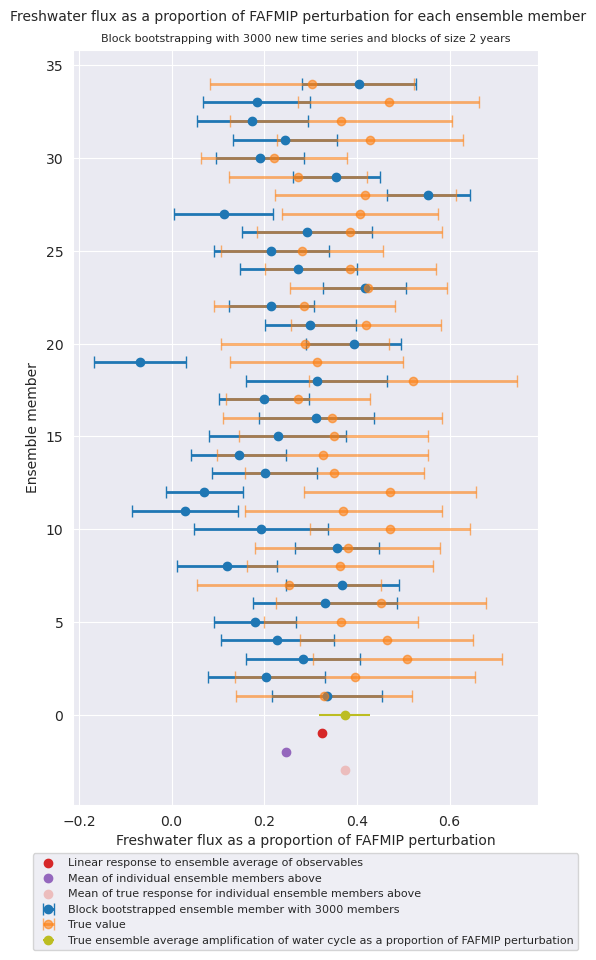

In [6]:
import seaborn as sns
import matplotlib as mpl
sns.set_style(style="darkgrid")
mpl.rcParams['figure.dpi'] = 100

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
fig,ax=plt.subplots(figsize=(6,10))
plt.errorbar(trend_uncertainty_bootstrap_mean_method1, np.linspace(1,34,34),xerr=trend_uncertainty_bootstrap_std_method1,fmt ='o',
        color='tab:blue',ms=6, capsize=4,elinewidth=2,label='Block bootstrapped ensemble member with 3000 members')
plt.errorbar(mean_boot, np.linspace(1,34,34),xerr=std_boot,fmt ='o', color='tab:orange',alpha=0.6,
        ms=6, capsize=4,elinewidth=2, label='True value')

ax.set_ylabel('Ensemble member')
ax.set_xlabel('Freshwater flux as a proportion of FAFMIP perturbation')
ax.errorbar(3.7330247766012464e-01,0,xerr=0.055182248268658855, color='tab:olive',fmt ='o',
        ms=6,label='True ensemble average amplification of water cycle as a proportion of FAFMIP perturbation') #this value comes from true_freshwater_fluxes.ipynb

ax.scatter(0.3240361691540233,-1,color='tab:red',label='Linear response to ensemble average of observables') #this value comes from linear_response_CESM_ensemblemean.ipynb

ax.scatter(np.average(trend_uncertainty_bootstrap_mean_method1,weights=trend_uncertainty_bootstrap_std_method1),-2,color='tab:purple',label='Mean of individual ensemble members above')
ax.scatter(np.average(mean_boot,weights=std_boot),-3,color='#ECBDBD',label='Mean of true response for individual ensemble members above')

ax.legend(loc='lower center',bbox_to_anchor=(0.5,-0.2),fontsize=8)
plt.title('Block bootstrapping with 3000 new time series and blocks of size 2 years',fontsize=8)
plt.suptitle('Freshwater flux as a proportion of FAFMIP perturbation for each ensemble member',fontsize=10, y=0.92)
mpl.pyplot.savefig('historical_indiv_ensemble_integ.png', dpi=300,bbox_inches='tight')

### Select for ensemble members which meet certain significance criteria
The method above works well for some members and not for others. If we were to look closer, we can see that members that are not capturing the response tend to have insignificant linear trends (compared to the scale of internal variability). One way to see this is choosing ensemble member 18 above in the individual example - here, the p value of the linear trend is insignificant for all regions.

We come up with sufficient (but not necessary) criteria for correctly capturing the true response. First we need to calculate pvalues. We calculate the p value from the confidence interval after bootstrapping (of the change in last 5 years compared to first 5 years). We could pretty equivalently use the p value of the original linear fit to the trend.

In [4]:
# We calculate the two forms of p value for the salt trends in the file  pvalue_salt_trends.py
import os
import pickle
cwd = os.getcwd() #current working directory

with open(cwd+"/pickled_files/pvalue_from_bootstrap", "rb") as fp:   #Unpickling the pvalues for each region for each ensemble member from block bootstrapping
    pvalue_bootstrap_store=pickle.load(fp)

In [5]:
## We first look at the mean of the pvalues in each of the regions across ensemble members
for j in range(0,6):
    print(pvalue_bootstrap_store[:,j].mean())
    
#We see that generally regions 2,6 are significant and regions 1,3,4,5 are not significant - in this case the signal is largely natural variability and not forced resposne

1.308228172132575e-01
0.0489725359205423
0.058488125015546955
0.12897569650813853
0.1531065940541366
0.004712437316236065


In [6]:
# After some playing around, one restriction that seems to guarantee finding the correct response is Let's try regions 2 and 6 have to have p value < 0.05
#regions 1,3,5 have to have p value <0.18. No restrictions for region 4 (doesn't seem to affect)

#Note that we can make these restrictions stricter too - can place a restriction on region 4, but it just eliminates more members that are actually doing well. 

#It is important that these are sufficient but not necessary conditions 

xx=np.linspace(1,34,34)

for i in range(0,34):    
    if pvalue_bootstrap_store[i,0]>0.18:
        trend_uncertainty_bootstrap_mean_method1[i]=np.nan
        trend_uncertainty_bootstrap_std_method1[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan
        xx[i]=np.nan
        
    if pvalue_bootstrap_store[i,1]>0.05:
        trend_uncertainty_bootstrap_mean_method1[i]=np.nan
        trend_uncertainty_bootstrap_std_method1[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan
        xx[i]=np.nan

    if pvalue_bootstrap_store[i,2]>0.18: 
        trend_uncertainty_bootstrap_mean_method1[i]=np.nan
        trend_uncertainty_bootstrap_std_method1[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan
        xx[i]=np.nan

#no restriction on fourth region

  
    if pvalue_bootstrap_store[i,4]>0.18:
        trend_uncertainty_bootstrap_mean_method1[i]=np.nan
        trend_uncertainty_bootstrap_std_method1[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan
        xx[i]=np.nan

    if pvalue_bootstrap_store[i,5]>0.05: 
        trend_uncertainty_bootstrap_mean_method1[i]=np.nan
        trend_uncertainty_bootstrap_std_method1[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan
        xx[i]=np.nan

/state/partition1/job-32407813/ipykernel_1197494/1994601639.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(x) for x in xx_mods]) #set the labels and make them integers


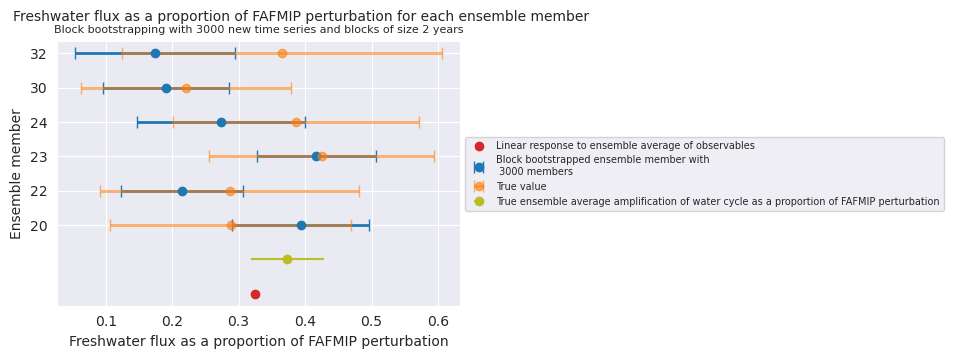

In [7]:
import seaborn as sns
import matplotlib as mpl
sns.set_style(style="darkgrid")
mpl.rcParams['figure.dpi'] = 100
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
fig,ax=plt.subplots(figsize=(6.5,3.5))


xx_mod=xx[np.logical_not(np.isnan(xx))]
trend_mod=trend_uncertainty_bootstrap_mean_method1[np.logical_not(np.isnan(xx))]
trend_std_mod=trend_uncertainty_bootstrap_std_method1[np.logical_not(np.isnan(xx))]
mean_boot_mod=mean_boot[np.logical_not(np.isnan(xx))]
std_boot_mod=std_boot[np.logical_not(np.isnan(xx))]



plt.errorbar(trend_mod, np.linspace(1,len(xx_mod),len(xx_mod)),xerr=trend_std_mod,fmt ='o',
        color='tab:blue',ms=6, capsize=4, elinewidth=2, label='Block bootstrapped ensemble member with \n 3000 members')
plt.errorbar(mean_boot_mod,np.linspace(1,len(xx_mod),len(xx_mod)),xerr=std_boot_mod,fmt ='o', color='tab:orange',
        ms=6, capsize=4,elinewidth=2, alpha=0.6, label='True value')


xx_mods=np.append(np.array([1,1,1]),xx_mod) #make labels (the three ones at the beginning are for labels we will get rid of)
ax.set_yticklabels([int(x) for x in xx_mods]) #set the labels and make them integers


yticks = plt.gca().yaxis.get_major_ticks()
for i in range(len(xx_mods)):
    if i<3:
        yticks[i].set_visible(False) #get rid of labels for non ensemble members


ax.set_ylabel('Ensemble member')
ax.set_xlabel('Freshwater flux as a proportion of FAFMIP perturbation')
ax.errorbar(3.7330247766012464e-01,0,xerr=0.055182248268658855, color='tab:olive',fmt ='o',
        ms=6,label='True ensemble average amplification of water cycle as a proportion of FAFMIP perturbation') #this value comes from true_freshwater_fluxes.ipynb

ax.scatter(0.3240361691540233,-1,color='tab:red',label='Linear response to ensemble average of observables') #this value comes from linear_response_CESM_ensemblemean.ipynb

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=7)
#ax.legend(loc='right',bbox_to_anchor=(4,-0.4),fontsize=8)
plt.title('Block bootstrapping with 3000 new time series and blocks of size 2 years',fontsize=8)
plt.suptitle('Freshwater flux as a proportion of FAFMIP perturbation for each ensemble member',fontsize=10, y=0.97)
mpl.pyplot.savefig('historical_indiv_ensemble_newstyle_integ.png', dpi=300,bbox_inches='tight')